Esta documentacao e para reparar um erro que foi realizado durante o processamento de dados, visto que nos casos de cancer e de tumores benignos e especificado quais canais das imagens esta presente o cancer. Alem disso, os casos actionable foram retirados do dataset, visto que e incerto se sao normal ou cancer.

In [3]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

2024-06-14 09:55:48.179566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 09:55:49.195549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
#Código para renomear a path do training set
root_dir = r"/media/breno/TOSHIBA EXT/DukeDBT/TestDataset/manifest-1617905855234/Breast-Cancer-Screening-DBT"

#Acha o folder
for foldername, subfolders, filenames in os.walk(root_dir):
    for subfolder in subfolders:
        #Checa se tem o "-NA", que era o que tinha de diferente
        if '-NA' in subfolder:
            #Tira o "-NA" e deixa vazio colcando ''
            new_subfolder = subfolder.replace('-NA', '')
            old_path = os.path.join(foldername, subfolder)
            new_path = os.path.join(foldername, new_subfolder)
            #Faz o rename
            os.rename(old_path, new_path)

In [24]:
#Ler os csvs das paths e da classificao de cada imagem
descriptive_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TestDataset/BCS-DBT-file-paths-test-v2.csv"
classification_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TestDataset/BCS-DBT-labels-test-PHASE-2.csv"
boxes_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TestDataset/BCS-DBT-boxes-test-v2-PHASE-2-Jan-2024.csv"


df_descriptive = pd.read_csv(descriptive_csv_path)
df_classification = pd.read_csv(classification_csv_path)
df_boxes = pd.read_csv(boxes_csv_path)

#Essa path é para adicionar antes da descriptive_path para ele achar as imagens no meu PC
additional_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TestDataset/manifest-1617905855234/" 

#Path adicional para achar o folder de test
data_folder = r"/media/breno/08FE0999FE097FE4/Breno/TCC/fixedBenignCancer/test"

#Folder das classes
class_folders = ['benign', 'cancer']
for folder in class_folders:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)

for index, row in df_descriptive.iterrows():
    descriptive_path = os.path.join(additional_path, row['descriptive_path'])
    patient_id = row['PatientID']
    view = row['View']
    
    ds = dicom.dcmread(descriptive_path)
    
    classification_row = df_classification[(df_classification['PatientID'] == patient_id) & 
                                           (df_classification['StudyUID'] == row['StudyUID']) & 
                                           (df_classification['View'] == view)]
    
    classification = classification_row.iloc[0]['Normal'], classification_row.iloc[0]['Actionable'], classification_row.iloc[0]['Benign'], classification_row.iloc[0]['Cancer']
    
    
    if classification[2] == 1 or classification[3] == 1:  # benign ou cancer
        box_row = df_boxes[(df_boxes['PatientID'] == patient_id) & 
                           (df_boxes['StudyUID'] == row['StudyUID']) & 
                           (df_boxes['View'] == view)]
        if not box_row.empty:
            slice_index = box_row.iloc[0]['Slice']
        else:
            slice_index = 0
        
       
        pixel_array = ds.pixel_array[slice_index]
        
      
        pixel_array = pixel_array.astype(np.float32)
        pixel_array -= np.min(pixel_array)
        pixel_array /= np.max(pixel_array)
        pixel_array *= 255
        pixel_array = pixel_array.astype(np.uint8)
        
       
        image = Image.fromarray(pixel_array)
        
        
        if classification[2] == 1:
            class_folder = 'benign'
        else:
            class_folder = 'cancer'
            
        image_name = f"{patient_id}_{view}.png"
        image.save(os.path.join(data_folder, class_folder, image_name))

In [26]:
#Ler os csvs das paths e da classificao de cada imagem
descriptive_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TrainingDataset/BCS-DBT-file-paths-train-v2.csv"
classification_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TrainingDataset/BCS-DBT-labels-train-v2.csv"
boxes_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TrainingDataset/BCS-DBT-boxes-train-v2.csv"


df_descriptive = pd.read_csv(descriptive_csv_path)
df_classification = pd.read_csv(classification_csv_path)
df_boxes = pd.read_csv(boxes_csv_path)

#Essa path é para adicionar antes da descriptive_path para ele achar as imagens no meu PC
additional_path = r"/media/breno/TOSHIBA EXT/DukeDBT/TrainingDataset/manifest-1617905855234" 

#Path adicional para achar o folder de test
data_folder = r"/media/breno/08FE0999FE097FE4/Breno/TCC/fixedBenignCancer/train"

#Folder das classes
class_folders = ['benign', 'cancer']
for folder in class_folders:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)

for index, row in df_descriptive.iterrows():
    descriptive_path = os.path.join(additional_path, row['descriptive_path'])
    patient_id = row['PatientID']
    view = row['View']
    
    ds = dicom.dcmread(descriptive_path)
    
    classification_row = df_classification[(df_classification['PatientID'] == patient_id) & 
                                           (df_classification['StudyUID'] == row['StudyUID']) & 
                                           (df_classification['View'] == view)]
    
    classification = classification_row.iloc[0]['Normal'], classification_row.iloc[0]['Actionable'], classification_row.iloc[0]['Benign'], classification_row.iloc[0]['Cancer']
    
    
    if classification[2] == 1 or classification[3] == 1:  # benign ou cancer
        box_row = df_boxes[(df_boxes['PatientID'] == patient_id) & 
                           (df_boxes['StudyUID'] == row['StudyUID']) & 
                           (df_boxes['View'] == view)]
        if not box_row.empty:
            slice_index = box_row.iloc[0]['Slice']
        else:
            slice_index = 0
        
       
        pixel_array = ds.pixel_array[slice_index]
        
      
        pixel_array = pixel_array.astype(np.float32)
        pixel_array -= np.min(pixel_array)
        pixel_array /= np.max(pixel_array)
        pixel_array *= 255
        pixel_array = pixel_array.astype(np.uint8)
        
       
        image = Image.fromarray(pixel_array)
        
        
        if classification[2] == 1:
            class_folder = 'benign'
        else:
            class_folder = 'cancer'
            
        image_name = f"{patient_id}_{view}.png"
        image.save(os.path.join(data_folder, class_folder, image_name))

In [28]:
#Ler os csvs das paths e da classificao de cada imagem
descriptive_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/ValidationDataset/BCS-DBT-file-paths-validation-v2.csv"
classification_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/ValidationDataset/BCS-DBT-labels-validation-PHASE-2-Jan-2024.csv"
boxes_csv_path = r"/media/breno/TOSHIBA EXT/DukeDBT/ValidationDataset/BCS-DBT-boxes-validation-v2-PHASE-2-Jan-2024.csv"


df_descriptive = pd.read_csv(descriptive_csv_path)
df_classification = pd.read_csv(classification_csv_path)
df_boxes = pd.read_csv(boxes_csv_path)

#Essa path é para adicionar antes da descriptive_path para ele achar as imagens no meu PC
additional_path = r"/media/breno/TOSHIBA EXT/DukeDBT/ValidationDataset/manifest-1617905855234" 

#Path adicional para achar o folder de test
data_folder = r"/media/breno/08FE0999FE097FE4/Breno/TCC/fixedBenignCancer/val"

#Folder das classes
class_folders = ['benign', 'cancer']
for folder in class_folders:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)

for index, row in df_descriptive.iterrows():
    descriptive_path = os.path.join(additional_path, row['descriptive_path'])
    patient_id = row['PatientID']
    view = row['View']
    
    ds = dicom.dcmread(descriptive_path)
    
    classification_row = df_classification[(df_classification['PatientID'] == patient_id) & 
                                           (df_classification['StudyUID'] == row['StudyUID']) & 
                                           (df_classification['View'] == view)]
    
    classification = classification_row.iloc[0]['Normal'], classification_row.iloc[0]['Actionable'], classification_row.iloc[0]['Benign'], classification_row.iloc[0]['Cancer']
    
    
    if classification[2] == 1 or classification[3] == 1:  # benign ou cancer
        box_row = df_boxes[(df_boxes['PatientID'] == patient_id) & 
                           (df_boxes['StudyUID'] == row['StudyUID']) & 
                           (df_boxes['View'] == view)]
        if not box_row.empty:
            slice_index = box_row.iloc[0]['Slice']
        else:
            slice_index = 0
        
       
        pixel_array = ds.pixel_array[slice_index]
        
      
        pixel_array = pixel_array.astype(np.float32)
        pixel_array -= np.min(pixel_array)
        pixel_array /= np.max(pixel_array)
        pixel_array *= 255
        pixel_array = pixel_array.astype(np.uint8)
        
       
        image = Image.fromarray(pixel_array)
        
        
        if classification[2] == 1:
            class_folder = 'benign'
        else:
            class_folder = 'cancer'
            
        image_name = f"{patient_id}_{view}.png"
        image.save(os.path.join(data_folder, class_folder, image_name))

In [1]:
#Função para visualização
def plot_image_counts2(folder_path):
    #Contadores pra plotar
    counts = {'cancer_type': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue',  'red'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

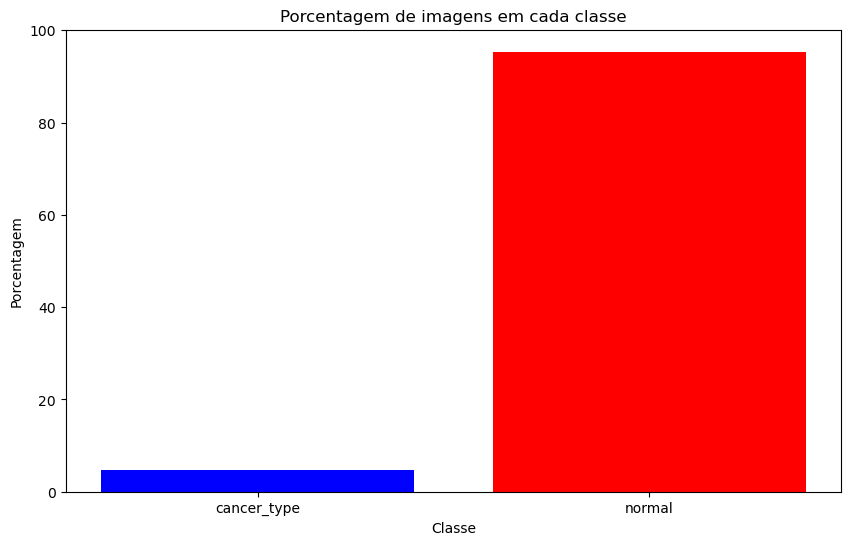

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         200     4.641448
normal             4109    95.358552


In [4]:
#Train set binário sem data augmentation
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
plot_image_counts2(folder_path)

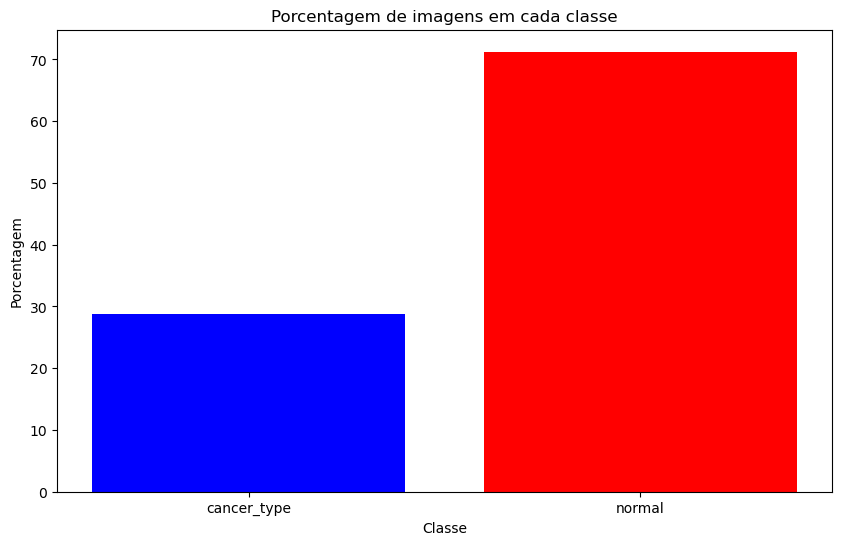

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         121    28.741093
normal              300    71.258907


In [5]:
#Test set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'
plot_image_counts2(folder_path)

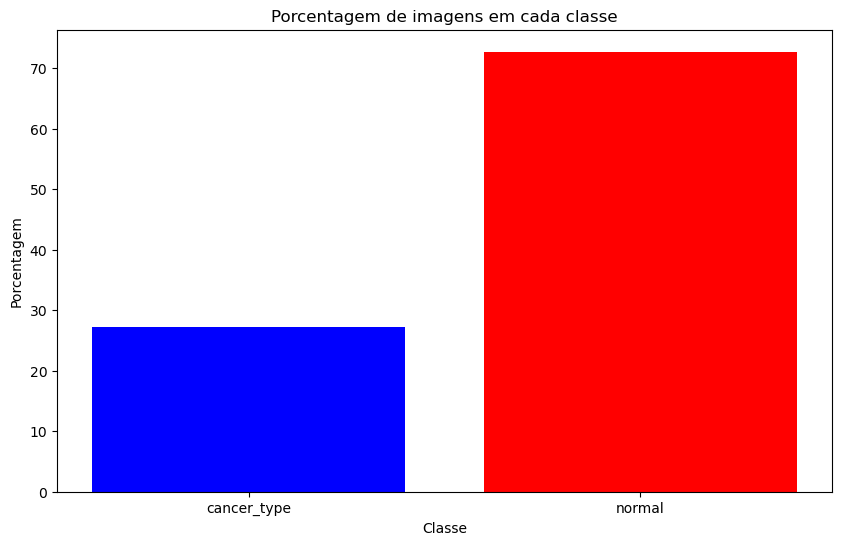

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type          75    27.272727
normal              200    72.727273


In [6]:
#Val set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
plot_image_counts2(folder_path)